In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from escnn import group, gspaces

import sys

sys.path.append("..")

from models.core.grid_convolution import ImplicitConv

# G-steerable Grid Convolution

Having learned how to define implicit steerable kernels, let us now use them inside a convolutional layer. 
In this example, we will consider the case of standard convolutions on a grid. See the next example for point cloud convolutions.

We first introduce toy data, initialize a convolutional layer, and apply it to the data. We then quantify equivariance error and make sure that it is sufficiently small.

Let us start by defining the group and the space we want to work on: SO(2) or O(2) on $\mathbb{R}^2$.

In [2]:
g = "so2"

In [3]:
if g == "o2":
    gspace = gspaces.flipRot2dOnR2()
elif g == "so2":
    gspace = gspaces.rot2dOnR2()

Our data is defined on a regular grid $64 \times 64$.

In [4]:
# Define the grid size
grid_size = 128

# Initialize the grid
x, y = torch.meshgrid(
    torch.linspace(0, 2 * torch.pi, grid_size),
    torch.linspace(0, 2 * torch.pi, grid_size),
    indexing="xy",
)

We now define a field on the grid, where the field has 2 components: scalar and vector.
- scalar: $sin(x) + cos(y)$,
- vector: $\left[sin(x) sin(y), cos(x) + cos(y)^2\right]$,

In [5]:
scalar = torch.sin(x) + torch.cos(y)
vector_x = torch.sin(x) * torch.sin(y)
vector_y = torch.cos(x) + torch.cos(y) ** 2

field = torch.stack([scalar, vector_x, vector_y], dim=0)
field = field.unsqueeze(0)

Let's visualize the input field:

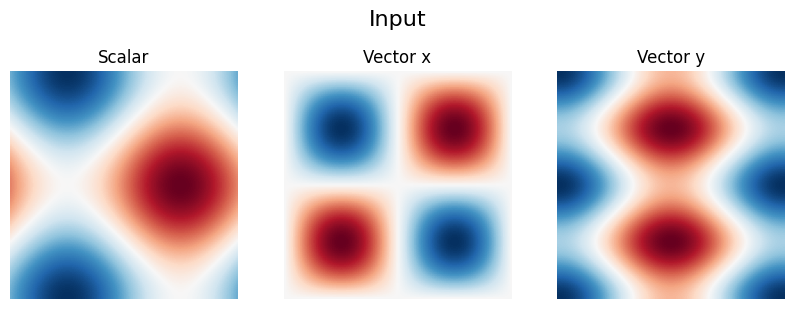

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y"]

for i in range(3):
    ax[i].imshow(field[0, i, :, :], cmap="RdBu")
    ax[i].axis("off")
    ax[i].set_title(component_names[i])

plt.subplots_adjust(hspace=0.5)
plt.text(0.5, 1.2, "Input", ha="center", fontsize=16, transform=ax[1].transAxes)
plt.show()

We now need to specify the transformation properties for each component of the field. 
The scalar components transforms according to the trivial representation, while the vector components - to standard representation.

In [7]:
scalar_repr = gspace.trivial_repr
vector_repr = gspace.fibergroup.standard_representation()

Furthermore, a single channel (single field) has a representation as direct sum of the scalar and vector representations.

In [8]:
channel_repr = group.directsum([scalar_repr, vector_repr])

**Important**: Implicit kernels also allow conditioning on global variables. Let's assume that our global variables is a stack of scalars (trivial representation).

**Remark**: Technically, one can condition them even on another field, including the input field itself. 
However, such approach will not scale well, as one will have to recompute the kernel again for each pixel (since there will be a different value of the conditioning field).

Let's assume we have scalar conditioning variables:

In [9]:
attr_repr = gspace.trivial_repr

Now we are ready to specify the resulting transformation rules of the input field, desired output field and the global attributes (kernel's condition).

In [10]:
c_in = 1
c_out = 5
c_attr = 8

in_repr = c_in * [channel_repr]
out_repr = c_out * [channel_repr]
attr_repr = c_attr * [attr_repr]

escnn's layers operate on geometric tensors, which are torch.tensors with assigned field types. 
A field type is the data type of a feature space that describes:
- the base space on which a feature field is living and its symmetries considered
- the transformation law of feature fields under the action of the fiber group

Let's define it for the input and output fields:

In [15]:
in_type = gspace.type(*in_repr)
out_type = gspace.type(*out_repr)
kernel_attr_type = gspace.type(*attr_repr)

We are now have everything we need to define a convolutional layer

In [16]:
conv = ImplicitConv(
    in_type=in_type,
    out_type=out_type,
    kernel_size=7,
    padding=3,
    kernel_attr_type=kernel_attr_type,
    n_layers=2,
    n_channels=12,
    init_scheme="he",
    stride=1,
)

Everything is set up, we can now apply the convolution to the input field. Let's embed our data in a geometric tensor, define attributes and apply the convolution.

In [17]:
field_gt = in_type(field)
attr = torch.randn(1, c_attr * 1)

In [18]:
out = conv(field_gt, attr).tensor.detach().numpy()

Let's visualize the output of the convolutional layer.

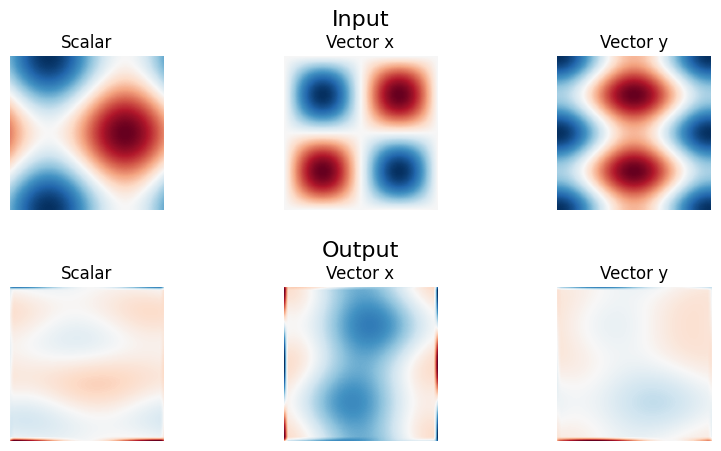

In [19]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y"]

for i in range(3):
    ax[0, i].imshow(field[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(3):
    ax[1, i].imshow(out[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(0.5, 1.2, "Input", ha="center", fontsize=16, transform=ax[0, 1].transAxes)
plt.text(0.5, 1.2, "Output", ha="center", fontsize=16, transform=ax[1, 1].transAxes)
plt.show()

### Equivariance test

To make sure the convolution is indeed equivariant, we need to do the equivariance test. 
We will do this by comparing $T(\mathcal{C}(x))$ with $\mathcal{C}(T(x))$, where $T$ is the transformation and $C$ is convolution.

Since we will applying continuous rotations to data on a regular grid, there will be discretization artefacts at the corners. To mask them off, let's define a circular mask.

In [20]:
circular_mask = torch.zeros(1, 1, grid_size, grid_size)
for i in range(grid_size):
    for j in range(grid_size):
        if (i - grid_size // 2) ** 2 + (j - grid_size // 2) ** 2 < (
            grid_size // 2 - 5
        ) ** 2:
            circular_mask[0, 0, i, j] = 1

Now the equivariance test.

In [21]:
errors = []

for el in list(gspace.testing_elements)[::10]:
    out1 = conv(field_gt, attr).transform(el).tensor.detach().numpy()
    out2 = conv(field_gt.transform(el), attr).tensor.detach().numpy()

    errs = np.abs(out1 - out2) / (np.abs(out1) + np.abs(out2) + 1e-5)
    errs *= circular_mask.numpy()
    errors.append(errs.mean())

print(f"Average absolute error for the layer: {np.mean(errors):.2e}")

Average absolute error for the layer: 4.78e-04


The relative error is quite small, but let's evaluate visually if the layer is indeed equivariant.

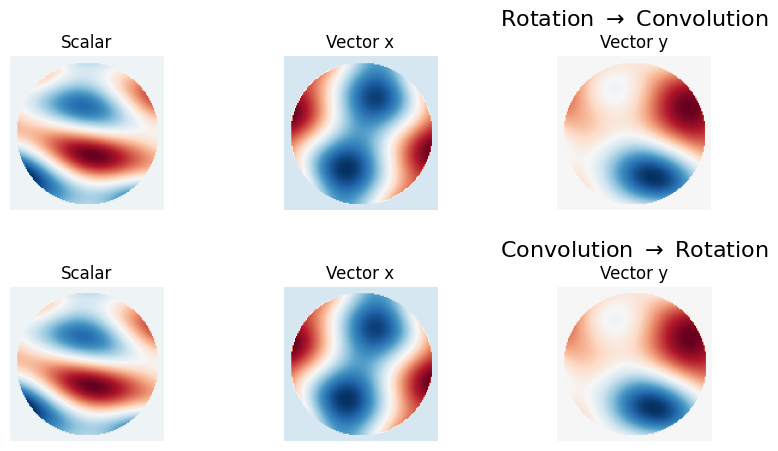

In [22]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
component_names = ["Scalar", "Vector x", "Vector y"]

for i in range(3):
    ax[0, i].imshow((out1 * circular_mask.numpy())[0, i, :, :], cmap="RdBu")
    ax[0, i].axis("off")
    ax[0, i].set_title(component_names[i])

for i in range(3):
    ax[1, i].imshow((out2 * circular_mask.numpy())[0, i, :, :], cmap="RdBu")
    ax[1, i].axis("off")
    ax[1, i].set_title(component_names[i])

# add space between the subplot rows
plt.subplots_adjust(hspace=0.5)
plt.text(
    0.5,
    1.2,
    r"Rotation $\rightarrow$ Convolution",
    ha="center",
    fontsize=16,
    transform=ax[0, 2].transAxes,
)
plt.text(
    0.5,
    1.2,
    r"Convolution $\rightarrow$ Rotation",
    ha="center",
    fontsize=16,
    transform=ax[1, 2].transAxes,
)
plt.show()